In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [215]:
dataframe = pd.read_csv('https://www.lombacovid.it/story.csv')

timeseries = dataframe['ospedalizzati_story'].copy()
timeseries.describe()

count     703.000000
mean     2304.928876
std      2361.289652
min       155.000000
25%       473.500000
50%      1200.000000
75%      3862.500000
max      9340.000000
Name: ospedalizzati_story, dtype: float64

In [216]:
def ADFTest(timeseries):

    print("If p-value < 0.05: the time series is stationary.\n")

    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    return

In [217]:
def plotACF(timeseries, differencing_times):

    plt.rcParams.update({'figure.figsize':(9,13), 'figure.dpi':80})
    fig, axes = plt.subplots(differencing_times+1, 2)

    for i in range(differencing_times+1):

        axes[i, 0].plot(timeseries)
        axes[i, 0].set_title(f"Differencing {i}")
        plot_acf(timeseries, ax=axes[i, 1], lags=20, title=f"ACF Differencing {i}")

        timeseries = timeseries.diff().dropna()

    plt.show()

In [218]:
def plotPACF(timeseries, differencing_times):

    plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':80})
    fig, axes = plt.subplots(1, 2)

    for i in range(differencing_times+1):
        timeseries = timeseries.diff().dropna()

    axes[0].plot(timeseries)
    axes[0].set_title(f"Differencing {i}")
    plot_pacf(timeseries, ax=axes[1], lags=20, title=f"PACF Differencing {i}", method='ywm')

    plt.show()

In [219]:
def plotTest(timeseries, pred_len, arima_order, fitting_method):

    train = timeseries[:-pred_len]
    test = timeseries[-pred_len:]
    model = ARIMA(train, order=arima_order)

    model_fit = model.fit(method=fitting_method)
    prediction = model_fit.forecast(pred_len)

    fc_series = pd.Series(prediction, index=test.index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[-100:], label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title(f'Forecast vs Actuals (MAPE: {np.mean( np.abs(prediction - test) / test )*100 :.2f}%)')
    plt.legend()
    plt.show()

    return

In [220]:
def plotMAPEs(timeseries, pred_len, arima_order, fitting_method='mle'):

    mapes = []
    for cut in range(400, len(timeseries.values), 10):

        train = timeseries.head(cut)[:-pred_len]
        test = timeseries.head(cut)[-pred_len:]

        model = ARIMA(train, order=arima_order)
        model_fit = model.fit(method=fitting_method)
        prediction = model_fit.forecast(pred_len)

        prediction_array = prediction.values
        test_array = test.values
        perc_array = np.abs(prediction_array - test_array) / test_array * 100
        mape = np.mean(perc_array)
        mapes.append(mape)

    mapes = np.array(mapes)
    plt.bar(range(len(mapes)), mapes)
    plt.title(f"MAPEs (mean: {np.mean(mapes):.2f}, std: {np.std(mapes):.2f})")
    plt.show()

    return

# ARIMA

## How to find the order of differencing (d)

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In case you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

The logged series seems to be more flat, but is it stationary ? Let’s compute a KPSS test to check this:

In [221]:
ADFTest(timeseries)

If p-value < 0.05: the time series is stationary.

ADF Statistic: -2.231883
p-value: 0.194878


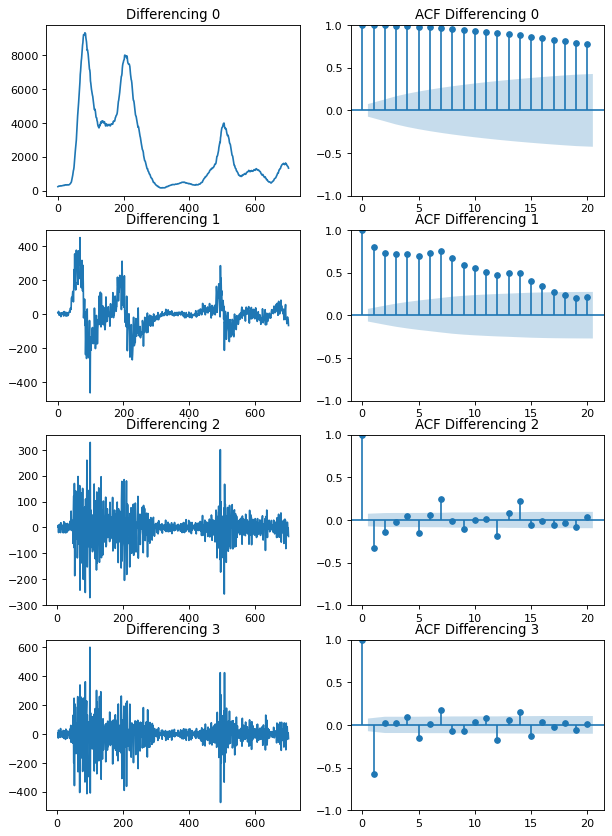

In [222]:
plotACF(timeseries, differencing_times=3)

In [223]:
ADFTest(timeseries.diff().diff().dropna())

If p-value < 0.05: the time series is stationary.

ADF Statistic: -5.156093
p-value: 0.000011


In [224]:
ADFTest(timeseries.diff().diff().diff().dropna())

If p-value < 0.05: the time series is stationary.

ADF Statistic: -11.906150
p-value: 0.000000


So d = 2 is decided.

## How to find the order of the AR term (p)

Partial autocorrelation (PACF) can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. Mathematically, PACF of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

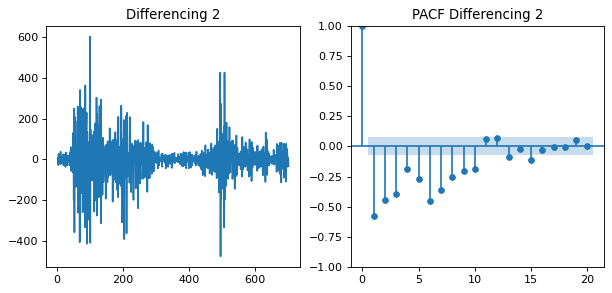

In [225]:
plotPACF(timeseries, differencing_times=2)

So p = 10 is decided.

## How to find the order of the MA term (q)

You can look at the ACF plot for the number of MA terms (an MA term is technically the error of the lagged forecast).

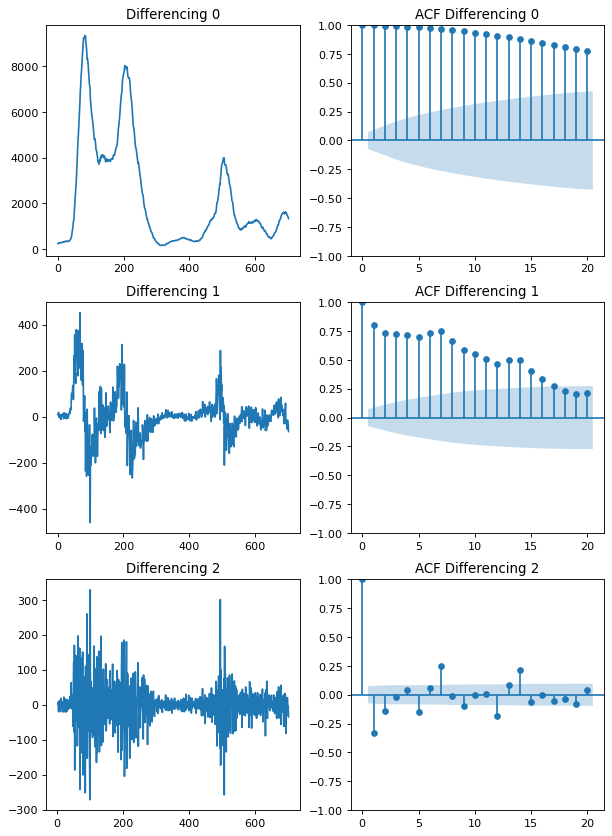

In [226]:
plotACF(timeseries, differencing_times=2)

Couple of lags are above the significance line, so:

q = 2

## The model

In [227]:
order = (10,2,2)

In [228]:
model = ARIMA(timeseries, order=order)
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'


                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  703
Model:                 ARIMA(10, 2, 2)   Log Likelihood               -3680.754
Date:                 Fri, 05 Aug 2022   AIC                           7387.509
Time:                         11:37:19   BIC                           7446.691
Sample:                              0   HQIC                          7410.385
                                 - 703                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3188      0.054      5.948      0.000       0.214       0.424
ar.L2         -0.6767      0.036    -18.726      0.000      -0.748      -0.606
ar.L3         -0.3525      0.039     -9.041 

The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

All the coefficients have not to be close to zero and their P-Value in the ‘P>|z|’ column has to be less than 0.05 for the respective X to be significant. We are ok!

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

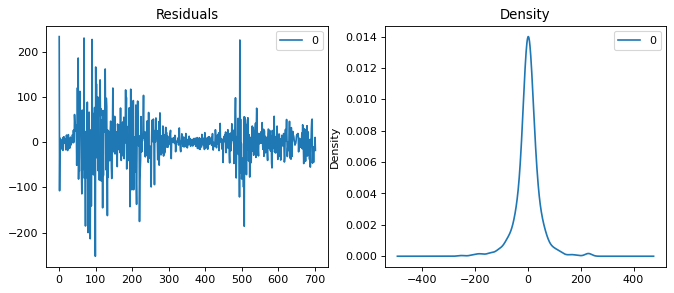

In [229]:
residuals = pd.DataFrame(model_fit.resid)

plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':80})
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## The test

In [230]:
pred_len = 7

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Users/stefanomartire/miniforge3/envs/lombacov

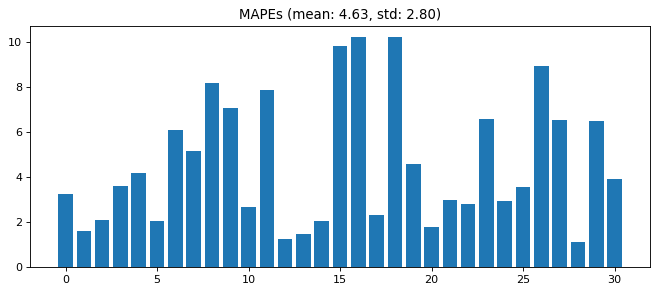

In [249]:
plotMAPEs(timeseries, pred_len, order, fitting_method='innovations_mle')

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'


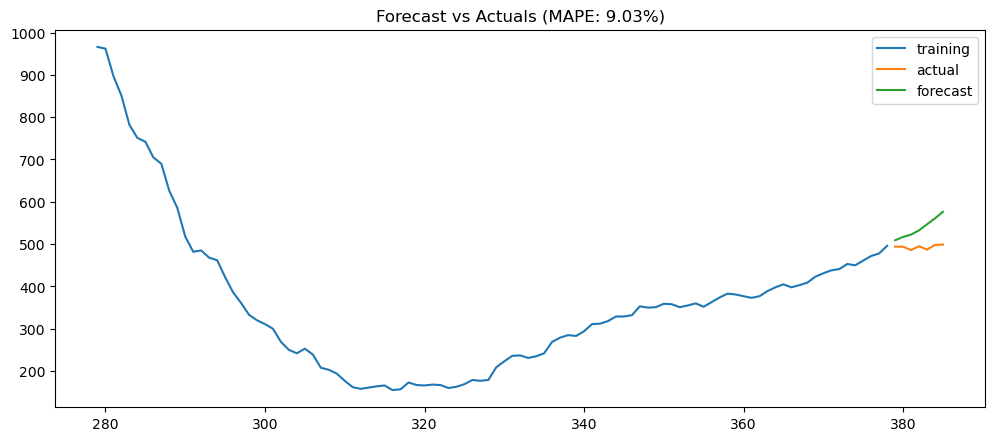

In [232]:
plotTest(timeseries.head(386), pred_len, order, fitting_method='innovations_mle')

# ARIMAX

In [233]:
exog_var = dataframe[['perc_story']].copy()
exog_var = exog_var.rolling(window=7, min_periods=1).mean()
exog_var.head(20)

,perc_story
0,1.490000
1,1.440000
2,1.500000
3,1.432500
4,1.478000
5,1.503333
6,1.460000
7,1.432857
8,1.380000
9,1.350000


In [234]:
shift_scope = 14
exog_var = exog_var.shift(shift_scope).dropna()

In [235]:
num_features = 14
for i in range(num_features):
    exog_var[f"perc_past_{i+1}"] = exog_var['perc_story'].shift(i+1)

exog_var = exog_var.dropna()
exog_var.head(20)

,perc_story,perc_past_1,perc_past_2,perc_past_3,perc_past_4,perc_past_5,perc_past_6,perc_past_7,perc_past_8,perc_past_9,perc_past_10,perc_past_11,perc_past_12,perc_past_13,perc_past_14
28,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333,1.478000,1.432500,1.500000,1.440000,1.490000
29,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333,1.478000,1.432500,1.500000,1.440000
30,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333,1.478000,1.432500,1.500000
31,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333,1.478000,1.432500
32,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333,1.478000
33,1.218571,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000,1.503333
34,1.121429,1.218571,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857,1.460000
35,1.167143,1.121429,1.218571,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000,1.432857
36,1.162857,1.167143,1.121429,1.218571,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000,1.380000
37,1.131429,1.162857,1.167143,1.121429,1.218571,1.311429,1.384286,1.398571,1.415714,1.434286,1.490000,1.435714,1.374286,1.378571,1.350000


In [236]:
timeseries_endog = timeseries[shift_scope+num_features:].copy()
timeseries_endog.head()

28    348.0
29    340.0
30    333.0
31    341.0
32    335.0
Name: ospedalizzati_story, dtype: float64

In [237]:
model = ARIMA(endog=timeseries_endog, exog=exog_var, order=order)
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endo

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  675
Model:                 ARIMA(10, 2, 2)   Log Likelihood               -3529.597
Date:                 Fri, 05 Aug 2022   AIC                           7115.195
Time:                         11:37:22   BIC                           7241.524
Sample:                              0   HQIC                          7164.117
                                 - 675                                         
Covariance Type:                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
perc_story      12.4356      7.828      1.589      0.112      -2.906      27.778
perc_past_1     28.7812      8.474      3.397      0.001      12.173      45.389
perc_past_2     -9.4876      9.231  

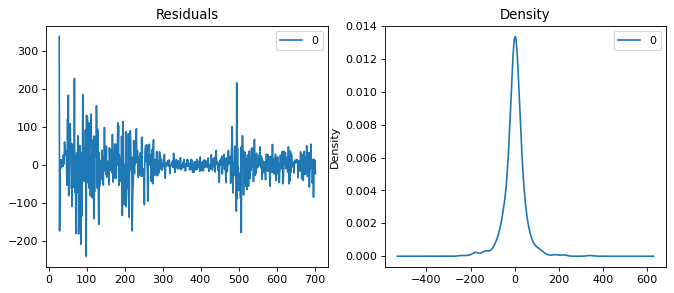

In [238]:
residuals = pd.DataFrame(model_fit.resid)

plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':80})
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [243]:
test = timeseries_endog[cut-pred_len:cut]
test

621    928.0
622    916.0
623    949.0
624    949.0
625    900.0
626    865.0
627    830.0
Name: ospedalizzati_story, dtype: float64

In [244]:
exog_test = exog_var[cut-pred_len:cut]
exog_test

,perc_story,perc_past_1,perc_past_2,perc_past_3,perc_past_4,perc_past_5,perc_past_6,perc_past_7,perc_past_8,perc_past_9,perc_past_10,perc_past_11,perc_past_12,perc_past_13,perc_past_14
621,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143,12.960000,12.725714,12.542857,12.861429,12.711429
622,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143,12.960000,12.725714,12.542857,12.861429
623,13.400000,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143,12.960000,12.725714,12.542857
624,13.260000,13.400000,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143,12.960000,12.725714
625,13.361429,13.260000,13.400000,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143,12.960000
626,13.537143,13.361429,13.260000,13.400000,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143,12.967143
627,13.557143,13.537143,13.361429,13.260000,13.400000,12.755714,12.720000,12.747143,12.972857,13.142857,13.257143,13.307143,13.168571,13.207143,13.167143


/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endo

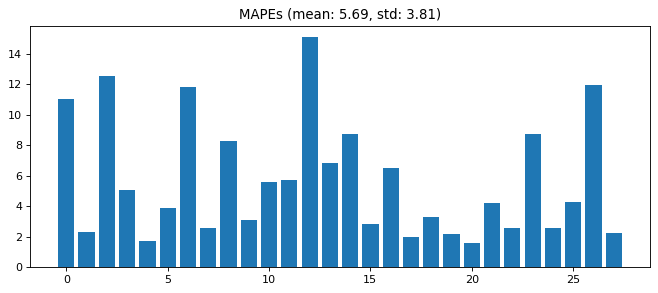

In [248]:
mapes = []
for cut in range(400, len(timeseries_endog.values), 10):

    train = timeseries_endog[:cut-pred_len]
    test = timeseries_endog[cut-pred_len:cut]
    exog_train = exog_var[:cut-pred_len]
    exog_test = exog_var[cut-pred_len:cut]

    model = ARIMA(endog=train, exog=exog_train, order=order)
    model_fit = model.fit(method='innovations_mle')
    prediction = model_fit.forecast(pred_len, exog=exog_test)

    prediction_array = prediction.values
    test_array = test.values
    perc_array = np.abs(prediction_array - test_array) / test_array * 100
    mape = np.mean(perc_array)
    mapes.append(mape)

mapes = np.array(mapes)
plt.bar(range(len(mapes)), mapes)
plt.title(f"MAPEs (mean: {np.mean(mapes):.2f}, std: {np.std(mapes):.2f})")
plt.show()